# Two examples of EMD on three component signals

## Produces Figures 22-29

The two higher frequency components are close together and the lower frequency component is separable. We ask what happens during the decomposition.

### Import Libraries

In [568]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.mlab as mlab
import numpy as np
import scipy
import PyEMD

## Example 1.
### 8 Hz, 23 Hz, 34 Hz

### Generate Data

In [569]:
np.random.seed(1)
nS = 1                                 # number of seconds
Fs = 600                               # sample rate (Hz)
t = np.arange(0,nS,1/Fs)               # time
f = np.array([8, 23, 34])              # frequencies
nT = len(t)                            # number of time steps
nF = len(f)                            # number of frequency components
p = np.random.uniform(low=0.0,         # phase offsets
                      high=2*np.pi,
                      size=len(f)) 
w = 1000                               # window for moving average, amplitude smoothing
noise_mean = 0.0
noise_std = 0.00

b = np.ones(shape=(nF,)) # base amplitude
#b = np.array([0.8, 1., 0.6, 0.4, 0.3]) # base amplitude

# amplitude of components
amp_flag = 'const' 
a = np.zeros((nF, nT))
if amp_flag == 'const':          # constant amplitude
    a = np.transpose(np.tile(b, (nT, 1))) 
elif amp_flag == 'vari':         # variable amplitude
    a = np.random.rand(nF, nT)
    for i in range(nF):
        a[i, :] = b[i] * np.convolve(a[i,:], np.ones(int(w)), 'same') / w
elif amp_flag == 'peri':         # periodic amplitude
    for i in range(nF):
        a[i, :] = b[i] * np.sin(2 * np.pi * f[i]/10 * t)

# define components, C
C = np.ndarray(shape=(nF,nT))
for i in range(nF):
    C[i, :] = a[i, :] * np.sin(2*np.pi*f[i]*t + p[i])

# add noise
noise = np.random.normal(loc=noise_mean, scale=noise_std, size=(nT,))
x = np.sum(C,0) + noise

In [570]:
from fractions import Fraction

c_p0 = Fraction(p[0] / np.pi).limit_denominator(max_denominator=10)
c_p1 = Fraction(p[1] / np.pi).limit_denominator(max_denominator=10)
c_p2 = Fraction(p[2] / np.pi).limit_denominator(max_denominator=10)

print(str(c_p0) + ', ' + str(c_p1) + ', ' + str(c_p2))

5/6, 13/9, 0


### Visualize signal and components

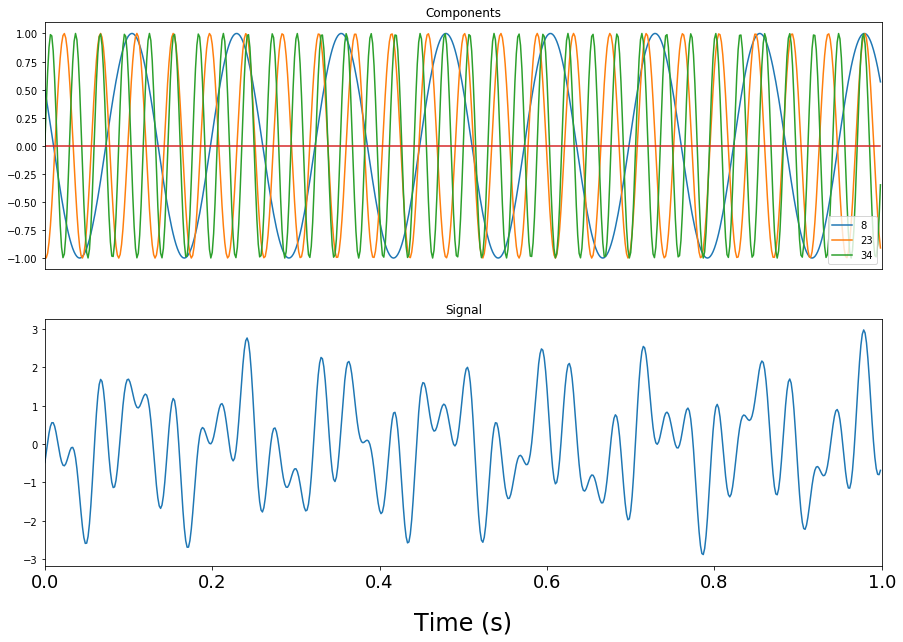

In [571]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
for j in range(nF):
    plt.plot(t, C[j,:], label=str(f[j]))

plt.plot(t, noise)
plt.title('Components')
plt.legend()
plt.xlim(0, nS)
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(t,x)
plt.title('Signal')
plt.xlim(0, nS)
plt.xticks(fontsize=18)

plt.xlabel('Time (s)', fontsize=24, labelpad=20)

#plt.savefig('plots/ex_emd_signal.pdf', bbox_inches = "tight")
plt.show()

### Compute analytic signal and instantaneous frequency

In [572]:
analytic_signal = scipy.signal.hilbert(C)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * Fs)

/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:1616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


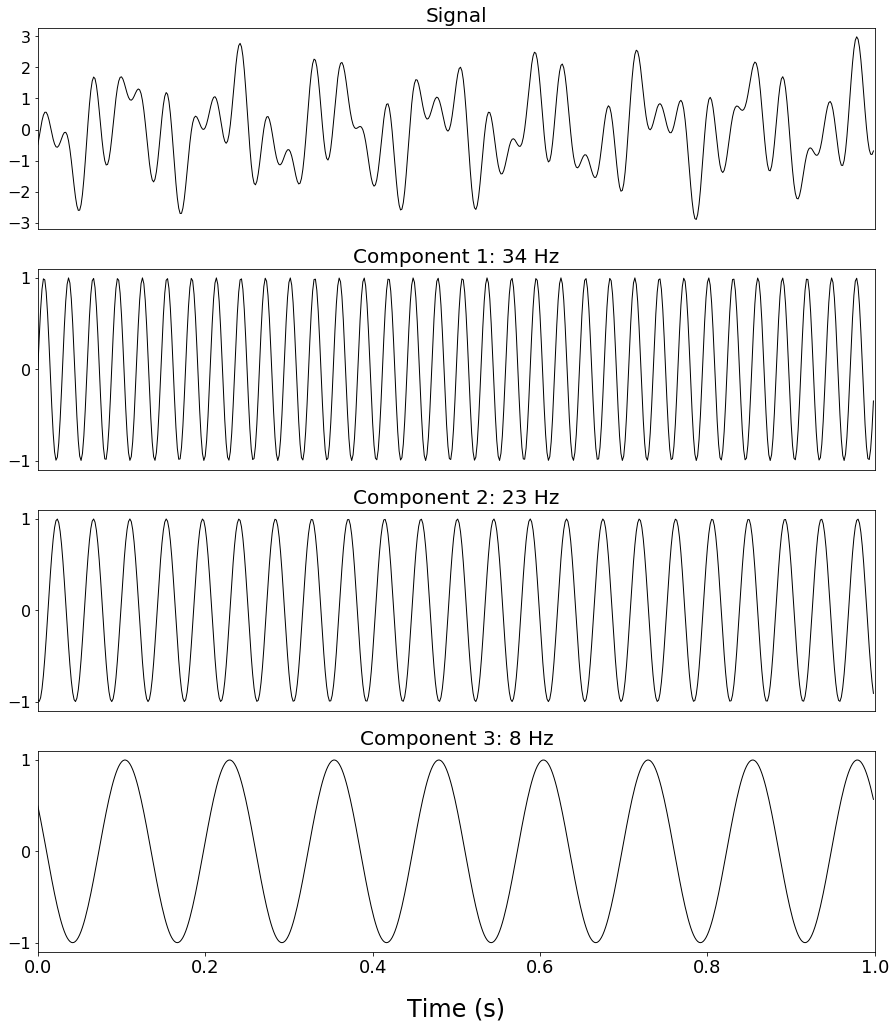

In [573]:
plt.figure(figsize=(15,17))

plt.subplot(nF+1,1,1)
plt.title('Signal', fontsize=20)
plt.plot(t, x, linestyle='-', linewidth='1.',color='black')
plt.xlim(0, nS)
plt.xticks([])
plt.yticks(fontsize=16)

for j in range(nF):
    plt.subplot(nF+1, 1, j+2)
    plt.title('Component ' + str(j+1) + ': ' + str(f[-(j+1)]) + ' Hz', fontsize=20)
    plt.plot(t, C[-(j+1),:], 'k', label=str(f[-(j+1)])+' Hz',  linestyle='-', linewidth='1.',color='black')
    #plt.legend(loc='upper right', fontsize=18, handlelength = 0)
    plt.xlim(0, nS)
    plt.yticks(fontsize=16)
    plt.locator_params(axis='y', nbins=3)
    if j < nF-1:
        plt.xticks([])

plt.xticks(fontsize=18)
plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/ch4-3-1_signal-8-23-34.pdf', bbox_inches = "tight")
plt.show()

## EMD instance

In [574]:
emd = PyEMD.EMD()

### Extract IMFs

In [575]:
# Extract imfs and residue
emd = PyEMD.EMD()
emd.emd(x)
imfs, res = emd.get_imfs_and_residue()
nIMF = imfs.shape[0]

### Compute analytic signal and instantaneous frequency

In [576]:
analytic_signal = np.zeros(shape=(nIMF, nT), dtype=np.complex_)
for k in range(nIMF):
    analytic_signal[k, :] = scipy.signal.hilbert(imfs[k, :])
    
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * Fs)

### Print median frequencies of IMFs

In [577]:
np.set_printoptions(suppress=True)
f_m = np.round(np.median(instantaneous_frequency,1),2)
for i in range(len(f_m)):
    print('IMF ' + str(i+1) + ': ' + str(f_m[i]))

IMF 1: 29.91
IMF 2: 8.15
IMF 3: 3.97
IMF 4: 0.28


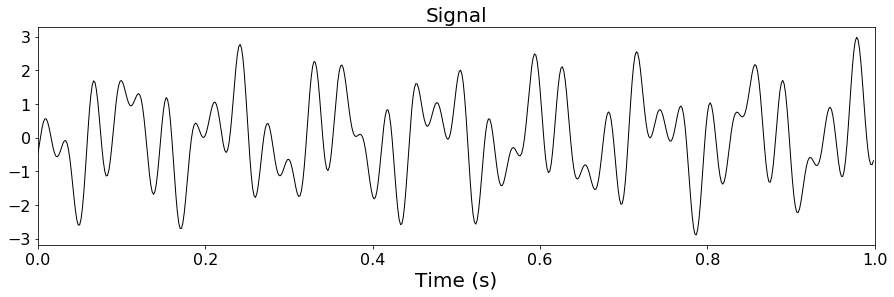

In [578]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(t, x, linewidth=1, color='black')
plt.xlim(0, nS)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylabel('Signal Strength', fontsize=18)
plt.title('Signal', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)

plt.savefig('plots/ch4-3-2_sig-8-23-34.pdf', bbox_inches = "tight")

plt.show()

### Plot data and IMFs

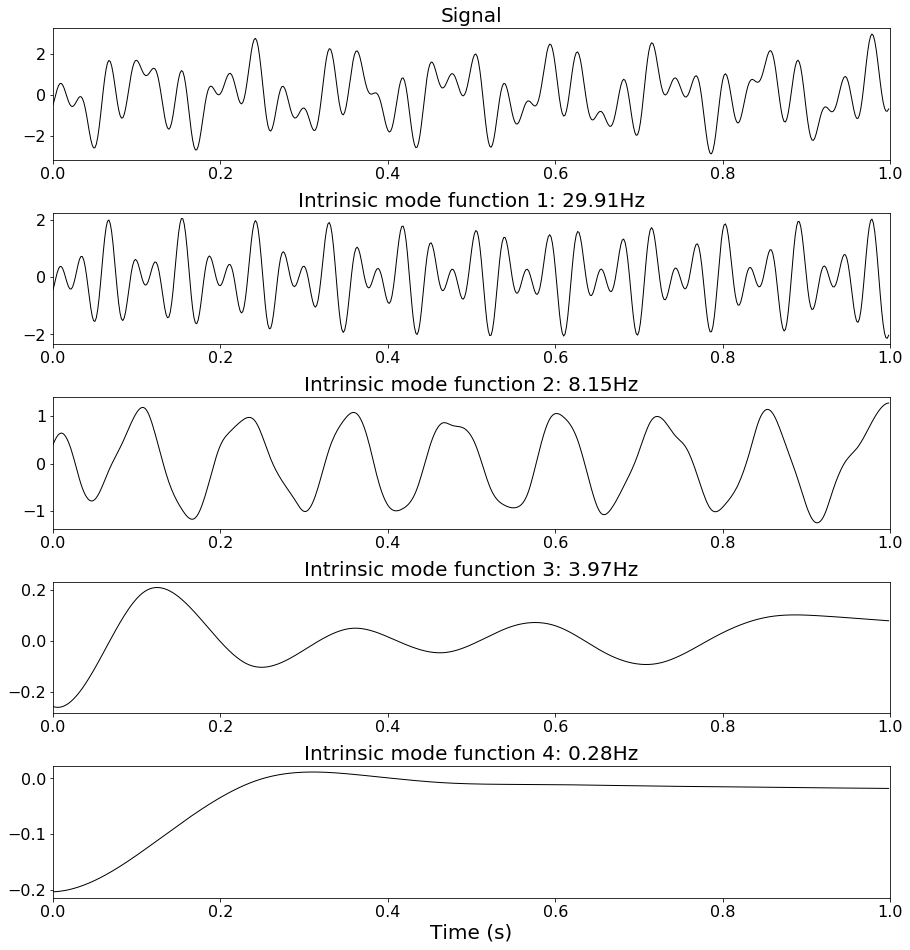

In [579]:
fig, ax = plt.subplots(figsize=(15,4*len(f_m)))
plt.subplot(nIMF+1,1,1)
plt.plot(t, x, linewidth=1, color='black')
plt.xlim(0, nS)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylabel('Signal Strength', fontsize=18)
plt.title('Signal', fontsize=20)
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(t, imfs[ii-1,:], linewidth=1, color='black')
    plt.xlim(0, nS)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis='y', nbins=3)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    if ii == nIMF:
        plt.xlabel('Time (s)', fontsize=20)

fig.subplots_adjust(hspace=0.4)

plt.savefig('plots/ch4-3-2_imfs-8-23-34.pdf', bbox_inches = "tight")
plt.show()

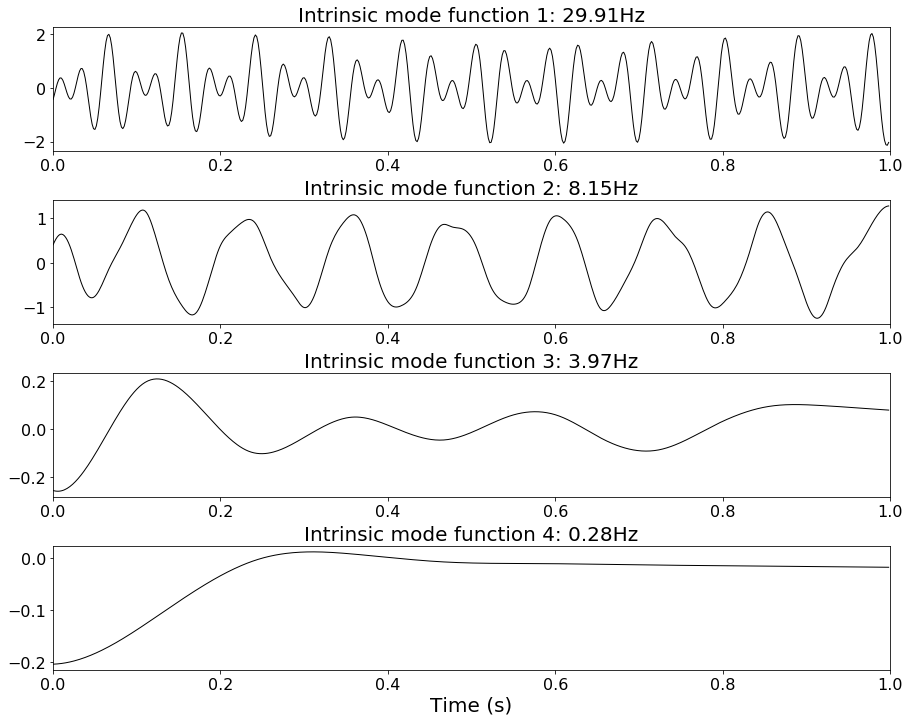

In [580]:
fig, ax = plt.subplots(figsize=(15,15))
plt.subplot(nIMF,1,1)
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(t, imfs[ii-1,:], linewidth=1, color='black')
    plt.xlim(0, nS)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis='y', nbins=3)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    if ii == nIMF:
        plt.xlabel('Time (s)', fontsize=20)

fig.subplots_adjust(hspace=0.4)

plt.savefig('plots/ch4-3-2_imfs-8-23-34_no_sig.pdf', bbox_inches = "tight")
plt.show()

### Plot periodogram

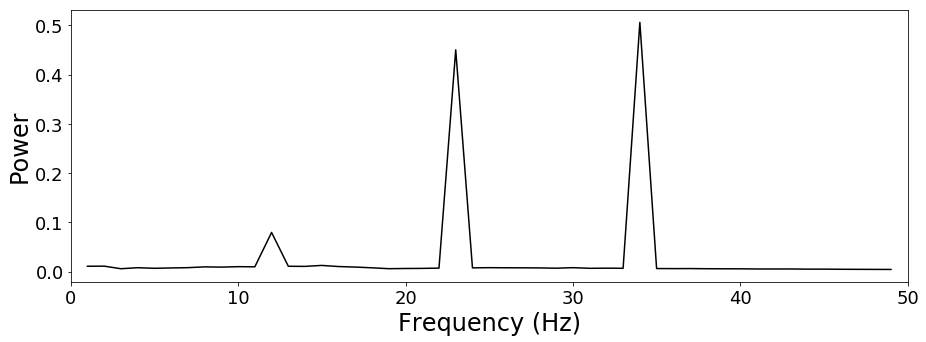

In [581]:
s1 = 0           # defines start of frequency window
s2 = 50          # defines end of frequency window

sig = imfs[0,:]
nfft = len(sig)    # n-point discrete Fourier Transform, default is length of signal

# compute fft and get frequencies
x_hat = np.fft.fft(sig, nfft)
timestep = 1/Fs
freq = np.fft.fftfreq(nfft, d=timestep)
       
# select only freq interval [s1, s2] to display power spectrum
f_sel = freq[(s1<freq)&(freq<s2)]

# compute periodogram (absolute value of fourier transform divided by number of points)
periodogram = (1/nfft) * np.abs(x_hat[(s1<freq)&(freq<s2)])

# plot    
plt.figure(figsize=(15,5))
plt.plot(f_sel, periodogram, color='black')
plt.xlim(s1, s2)
plt.xticks(fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=24)
plt.yticks(fontsize=18)
plt.ylabel('Power', fontsize=24)
plt.show()

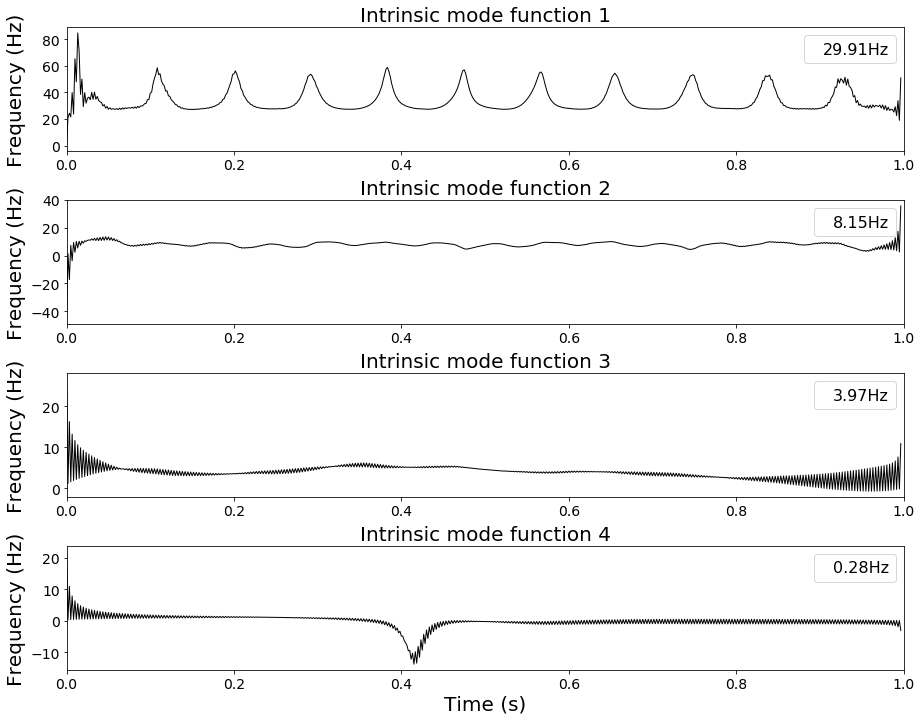

In [582]:
fig, ax = plt.subplots(figsize=(15,15))
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(t[0:-1], instantaneous_frequency[ii-1,:], linewidth=1, color='black', label=str(f_m[ii-1]) + 'Hz')
    plt.xlim(0,nS)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii), fontsize=20)# + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    plt.legend(loc='upper right', handlelength=0, fontsize=16)
    plt.ylabel('Frequency (Hz)', fontsize=20)
    if ii == nIMF:
        plt.xlabel('Time (s)', fontsize=20)

fig.subplots_adjust(hspace=0.4)
fig.align_ylabels()

plt.savefig('plots/ch4-3-3_inst_freq-8-23-34.pdf', bbox_inches = "tight")
plt.show()

### Zoom in on instantaneous frequencies

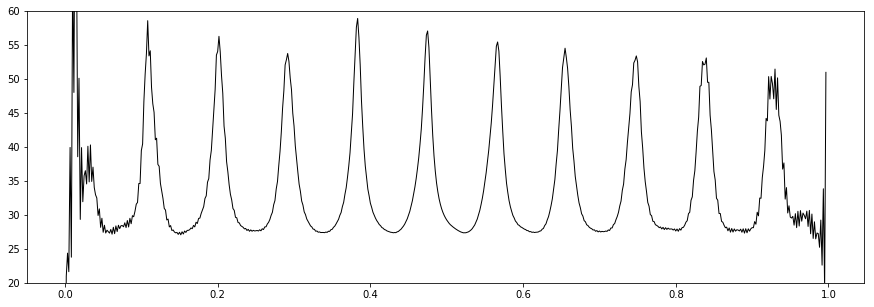

In [583]:
plt.figure(figsize=(15,5))
plt.plot(t[0:-1], instantaneous_frequency[0,:], linewidth=1, color='black', label=str(f_m[ii-1]) + 'Hz')
plt.ylim(20,60)
plt.show()

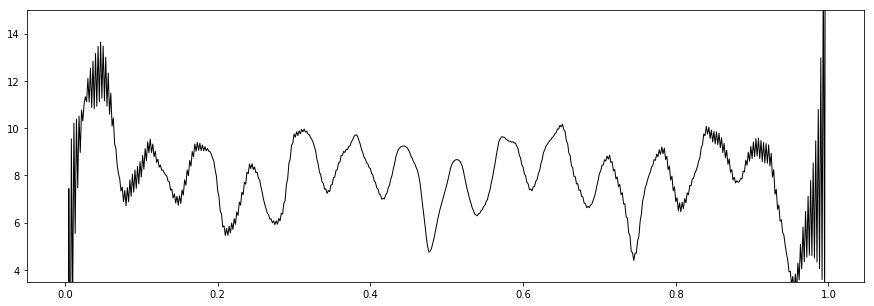

In [584]:
plt.figure(figsize=(15,5))
plt.plot(t[0:-1], instantaneous_frequency[1,:], linewidth=1, color='black', label=str(f_m[ii-1]) + 'Hz')
plt.ylim(3.5,15)
plt.show()

## Comparing bandpass filtering with EMD

### Define filter functions

In [585]:
# function defintion from:
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return b, a

# note: default padlen=3*max(len(a), len(b))
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

### Downsample and filter signal between 4 and 12 Hz

In [586]:
# first downsample again
factor = 1
Fs_filt = Fs/factor
xx = scipy.signal.decimate(x, q=factor, zero_phase=True)

# center
xx = xx - np.mean(xx)

# double check sample rate
print(Fs_filt)

600.0


/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:3424: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [587]:
x_filt = butter_bandpass_filter(data=xx, lowcut=4, highcut=12, fs=Fs_filt, order=3)

/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [588]:
analytic_signal_xfilt = scipy.signal.hilbert(x_filt)
amplitude_envelope_xfilt = np.abs(analytic_signal_xfilt)
instantaneous_phase_xfilt = np.unwrap(np.angle(analytic_signal_xfilt))
instantaneous_frequency_xfilt = (np.diff(instantaneous_phase_xfilt) /
                           (2.0*np.pi) * Fs_filt)

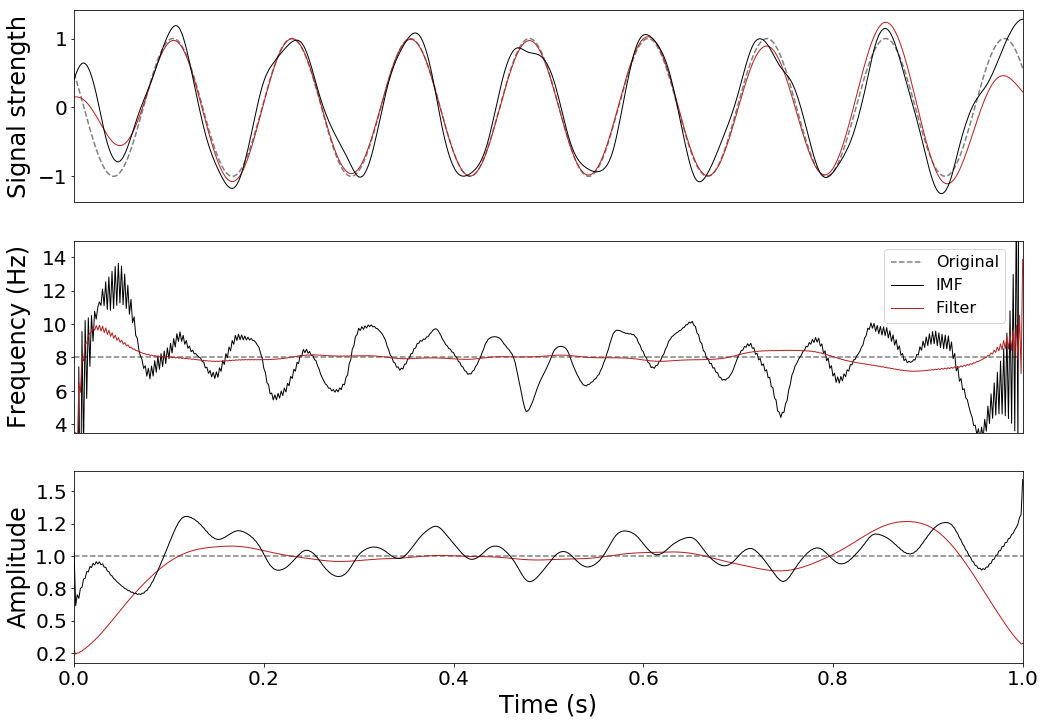

In [589]:
fig, ax = plt.subplots(figsize=(17,12))

plt.subplot(311)
plt.plot(np.linspace(0, nS, len(C[0,:])), C[0,:], linestyle='--', color='gray')
plt.plot(np.linspace(0, nS, len(x_filt)), x_filt, linewidth=1, color='firebrick')
plt.plot(np.linspace(0, nS, len(imfs[1,:])), imfs[1,:], linewidth=1, color='black')
plt.xlim(0,nS)
plt.xticks([])
plt.yticks([-1, 0, 1], fontsize=20)
plt.ylabel('Signal strength', fontsize=24)

plt.subplot(312)
plt.plot(t, 8*np.ones(shape=(len(t),)), linestyle='--', color='gray', label='Original')
plt.plot(t[0:-1], instantaneous_frequency[1,:], linewidth=1, color='black', label='IMF')
plt.plot(np.linspace(0, nS, len(instantaneous_frequency_xfilt)), instantaneous_frequency_xfilt, linewidth=1, color='firebrick', label='Filter')
plt.ylim(3.5,15)
plt.xlim(0,nS)
plt.xticks([])
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)
plt.ylabel('Frequency (Hz)', fontsize=24)
plt.legend(loc='upper right', bbox_to_anchor=(.99, 1), fontsize=16)

axi = plt.subplot(313)
plt.plot(np.linspace(0, nS, len(C[0,:])), np.ones(shape=(len(C[0,:]),)), linestyle='--', color='gray')
plt.plot(np.linspace(0, nS, len(x_filt)), amplitude_envelope_xfilt, linewidth=1, color='firebrick')
plt.plot(np.linspace(0, nS, len(imfs[1,:])), amplitude_envelope[1,:], linewidth=1, color='black')
plt.xlim(0,nS)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)
axi.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.xlabel('Time (s)', fontsize=24)
plt.ylabel('Amplitude', fontsize=24)

fig.align_ylabels()


plt.savefig('plots/ch4-3-4_analysis_8hz.pdf', bbox_inches = "tight")
plt.show()

### Error

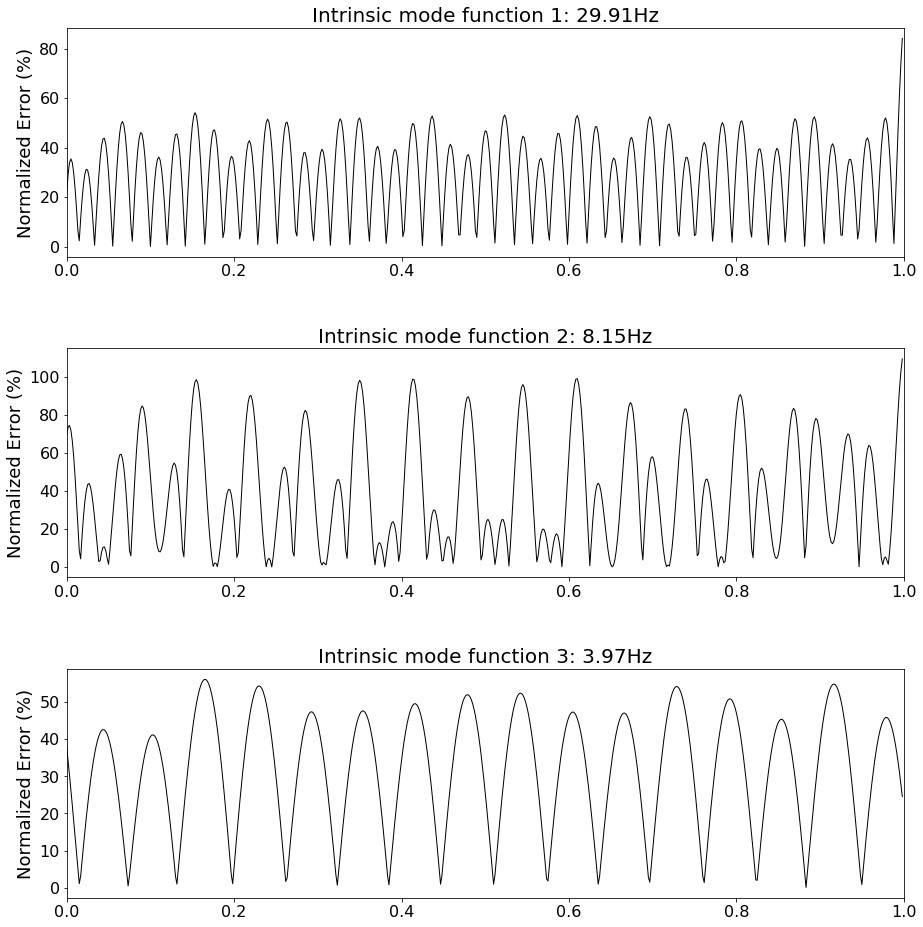

In [410]:
fig, ax = plt.subplots(figsize=(15,4*len(f_m)))
for ii in range(1,nF+1):
    plt.subplot(nF,1,ii)
    abs_err_ptwise = np.abs(C[-ii,:] - imfs[ii-1,:])                    # absolute pointwise error
    signal_range = np.abs(np.max(C[-ii,:]) + np.abs(np.min(C[-ii,:])))  # range, absolute max - absolute min
    rel_err = 100*abs_err_ptwise/signal_range                           # relative percent error
    plt.plot(t, rel_err, linewidth=1, color='black')
    plt.xlim(0, nS)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('Normalized Error (%)', fontsize=18)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    if ii == nIMF:
        plt.xlabel('Time (s)', fontsize=20)

fig.subplots_adjust(hspace=0.4)

#plt.savefig('plots/12_ex_emd_normalized_error.pdf', bbox_inches = "tight")
plt.show()

### Example of component vs. IMF
We can see the error being made.

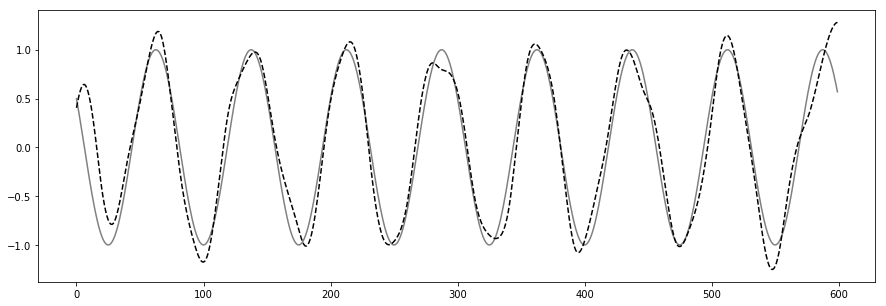

In [411]:
s1 = 0 
s2 = 1200
plt.figure(figsize=(15,5))
plt.plot(C[0, :], color='grey')
plt.plot(imfs[1,:], linestyle='--', color='black')
#plt.xlim(s1/Fs, s2/Fs)

## Example 2.
### 8 Hz, 76Hz, 123Hz

### Generate Data

In [592]:
np.random.seed(12)
nS = 1                                 # number of seconds
Fs = 2400                              # sample rate (Hz)
t = np.arange(0,nS,1/Fs)               # time
f = np.array([8, 76, 123])              # frequencies
nT = len(t)                            # number of time steps
nF = len(f)                            # number of frequency components
p = np.random.uniform(low=0.0,         # phase offsets
                      high=2*np.pi,
                      size=len(f)) 
w = 1000                               # window for moving average, amplitude smoothing
noise_mean = 0.0
noise_std = 0.00

b = np.ones(shape=(nF,)) # base amplitude
#b = np.array([0.8, 1., 0.6, 0.4, 0.3]) # base amplitude

# amplitude of components
amp_flag = 'const' 
a = np.zeros((nF, nT))
if amp_flag == 'const':          # constant amplitude
    a = np.transpose(np.tile(b, (nT, 1))) 
elif amp_flag == 'vari':         # variable amplitude
    a = np.random.rand(nF, nT)
    for i in range(nF):
        a[i, :] = b[i] * np.convolve(a[i,:], np.ones(int(w)), 'same') / w
elif amp_flag == 'peri':         # periodic amplitude
    for i in range(nF):
        a[i, :] = b[i] * np.sin(2 * np.pi * f[i]/10 * t)

# define components, C
C = np.ndarray(shape=(nF,nT))
for i in range(nF):
    C[i, :] = a[i, :] * np.sin(2*np.pi*f[i]*t + p[i])

# add noise
noise = np.random.normal(loc=noise_mean, scale=noise_std, size=(nT,))
x = np.sum(C,0) + noise

In [593]:
np.round(p, 5)

array([0.96863, 4.64987, 1.65446])

### Visualize signal and components

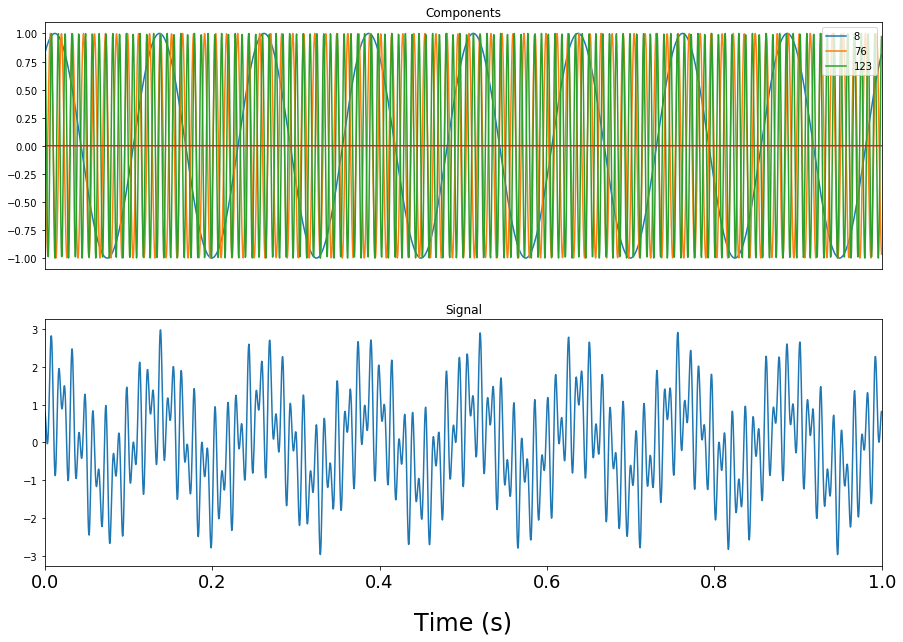

In [594]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
for j in range(nF):
    plt.plot(t, C[j,:], label=str(f[j]))

plt.plot(t, noise)
plt.title('Components')
plt.legend()
plt.xlim(0, nS)
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(t,x)
plt.title('Signal')
plt.xlim(0, nS)
plt.xticks(fontsize=18)

plt.xlabel('Time (s)', fontsize=24, labelpad=20)

#plt.savefig('plots/ex_emd_signal.pdf', bbox_inches = "tight")
plt.show()

### Compute analytic signal and instantaneous frequency

In [595]:
analytic_signal = scipy.signal.hilbert(C)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * Fs)

/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:1616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


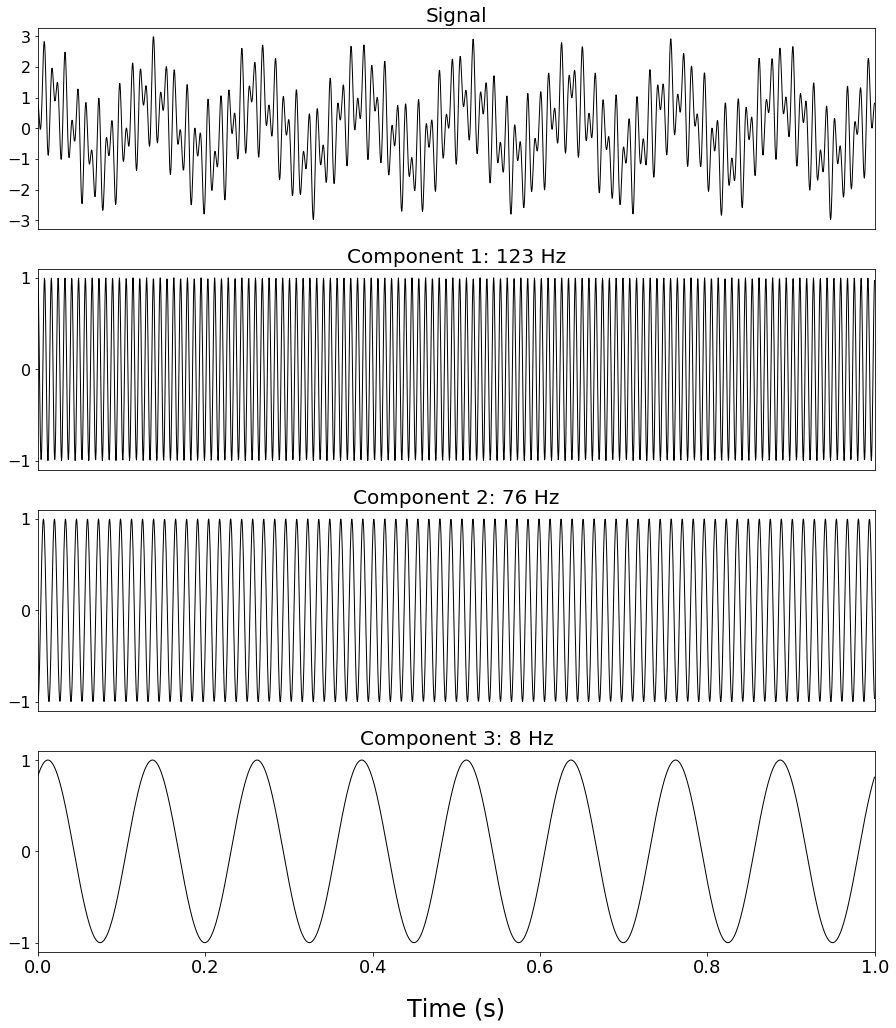

In [596]:
plt.figure(figsize=(15,17))

plt.subplot(nF+1,1,1)
plt.title('Signal', fontsize=20)
plt.plot(t, x, linestyle='-', linewidth='1.',color='black')
plt.xlim(0, nS)
plt.xticks([])
plt.yticks(fontsize=16)

for j in range(nF):
    plt.subplot(nF+1, 1, j+2)
    plt.title('Component ' + str(j+1) + ': ' + str(f[-(j+1)]) + ' Hz', fontsize=20)
    plt.plot(t, C[-(j+1),:], 'k', label=str(f[-(j+1)])+' Hz',  linestyle='-', linewidth='1.',color='black')
    plt.xlim(0, nS)
    plt.yticks(fontsize=16)
    plt.locator_params(axis='y', nbins=3)
    if j < nF-1:
        plt.xticks([])

plt.xticks(fontsize=18)
plt.xlabel('Time (s)', fontsize=24, labelpad=20)

plt.savefig('plots/ch4-3-5_signal_8-76-123.pdf', bbox_inches = "tight")
plt.show()

## EMD instance

In [597]:
emd = PyEMD.EMD()

### Extract IMFs

In [598]:
# Extract imfs and residue
emd = PyEMD.EMD()
emd.emd(x)
imfs, res = emd.get_imfs_and_residue()
nIMF = imfs.shape[0]

### Compute analytic signal and instantaneous frequency

In [599]:
analytic_signal = np.zeros(shape=(nIMF, nT), dtype=np.complex_)
for k in range(nIMF):
    analytic_signal[k, :] = scipy.signal.hilbert(imfs[k, :])
    
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * Fs)

### Print median frequencies of IMFs

In [600]:
np.set_printoptions(suppress=True)
f_m = np.round(np.median(instantaneous_frequency,1),2)
for i in range(len(f_m)):
    print('IMF ' + str(i+1) + ': ' + str(f_m[i]))

IMF 1: 109.62
IMF 2: 75.73
IMF 3: 9.14
IMF 4: 5.44
IMF 5: 1.62
IMF 6: 1.03
IMF 7: 0.03


### Plot data and IMFs

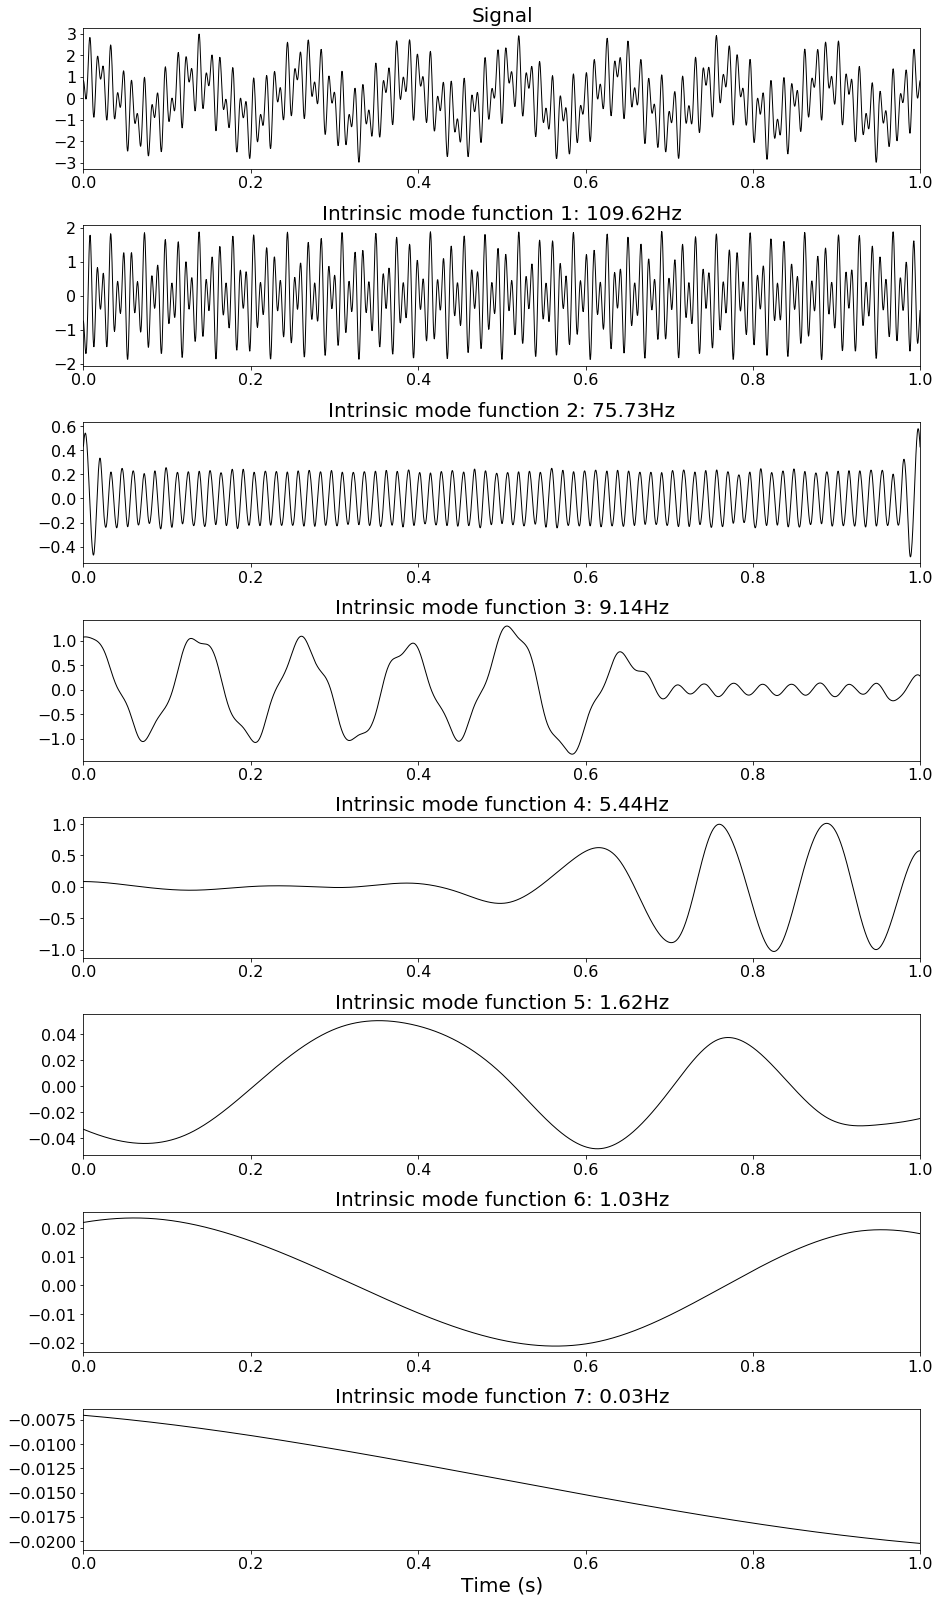

In [601]:
fig, ax = plt.subplots(figsize=(15,4*len(f_m)))
plt.subplot(nIMF+1,1,1)
plt.plot(t, x, linewidth=1, color='black')
plt.xlim(0, nS)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylabel('Signal Strength', fontsize=18)
plt.title('Signal', fontsize=20)
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(t, imfs[ii-1,:], linewidth=1, color='black')
    plt.xlim(0, nS)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    if ii == nIMF:
        plt.xlabel('Time (s)', fontsize=20)

fig.subplots_adjust(hspace=0.4)

plt.savefig('plots/ch4-3-6_imfs_8-76-123.pdf', bbox_inches = "tight")
plt.show()

### Plot power spectrum of IMF1 via Welch **LOG

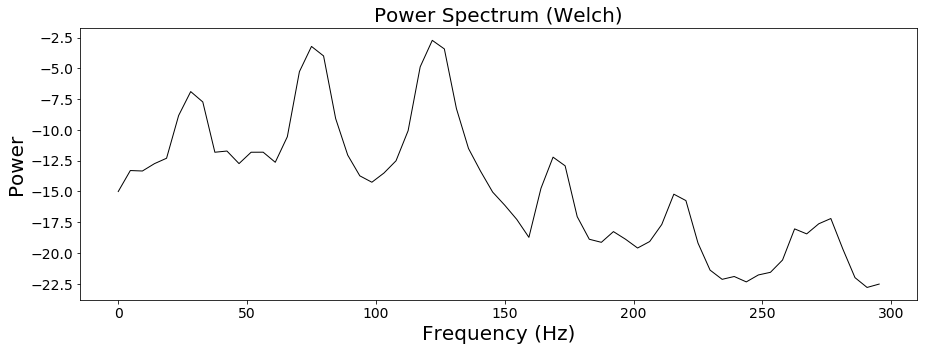

In [602]:
cut_off = 300
power, freqs = mlab.psd(imfs[0,:], NFFT=512, Fs=Fs)
plt.figure(figsize=(15,5))
plt.plot(freqs[freqs<cut_off], np.log(power[freqs<cut_off]), linewidth=1., color='black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Power Spectrum (Welch)', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Power', fontsize=20)
plt.show()

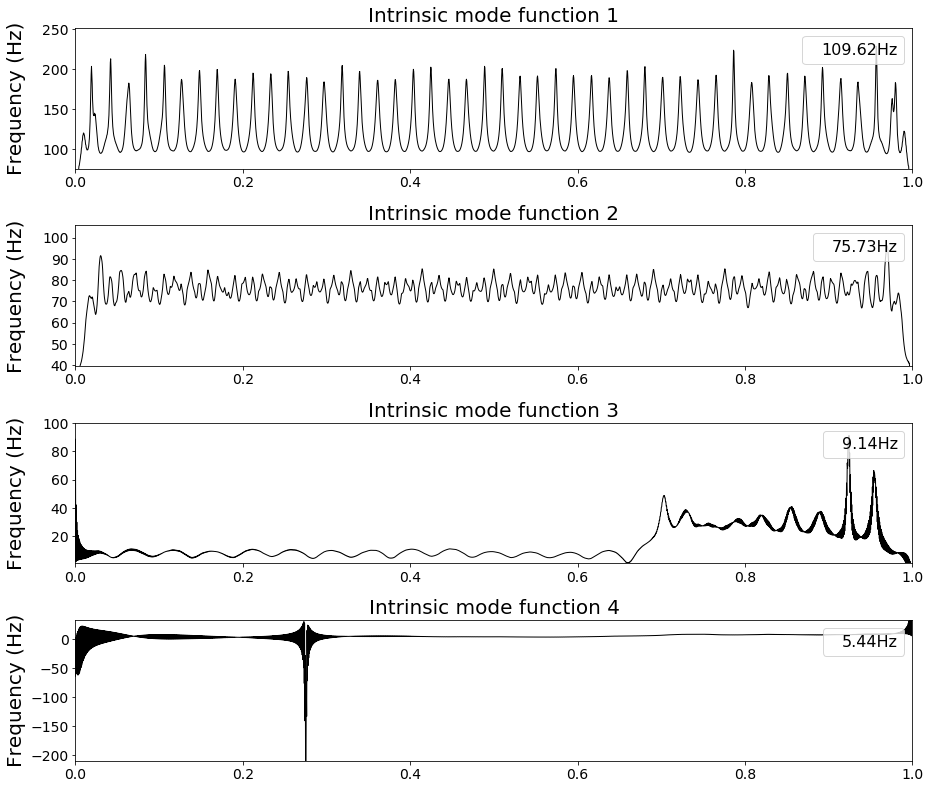

In [603]:
fig, ax = plt.subplots(figsize=(15,4*len(f_m)))
for ii in range(1,nIMF-2):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(t[0:-1], instantaneous_frequency[ii-1,:], linewidth=1, color='black', label=str(f_m[ii-1]) + 'Hz')
    plt.xlim(0,nS)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii), fontsize=20)# + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    plt.legend(loc='upper right', handlelength=0, fontsize=16)
    plt.ylabel('Frequency (Hz)', fontsize=20)
    plt.ylim(0.8*min(instantaneous_frequency[ii-1,int(Fs/100):nS-int(Fs/100)]), 1.1*max(instantaneous_frequency[ii-1,int(Fs/100):nS-int(Fs/100)]))
    if ii == nIMF:
        plt.xlabel('Time (s)', fontsize=20)

fig.subplots_adjust(hspace=0.4)
fig.align_ylabels()

plt.savefig('plots/ch4-3-7_inst_freq_8-76-123.pdf', bbox_inches = "tight")
plt.show()

### Zoom in on instantaneous frequencies

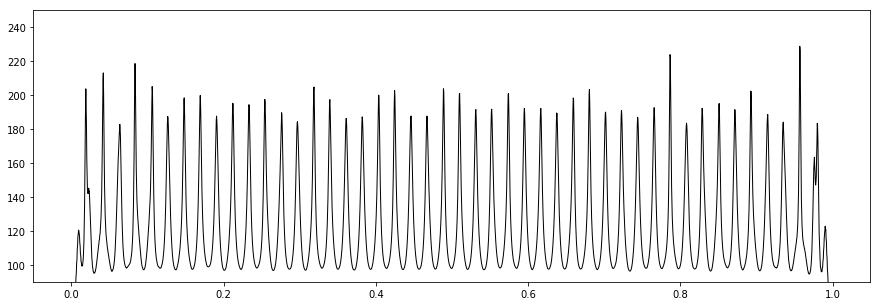

In [605]:
plt.figure(figsize=(15,5))
plt.plot(t[0:-1], instantaneous_frequency[0,:], linewidth=1, color='black', label=str(f_m[ii-1]) + 'Hz')
plt.ylim(90,250)
plt.show()

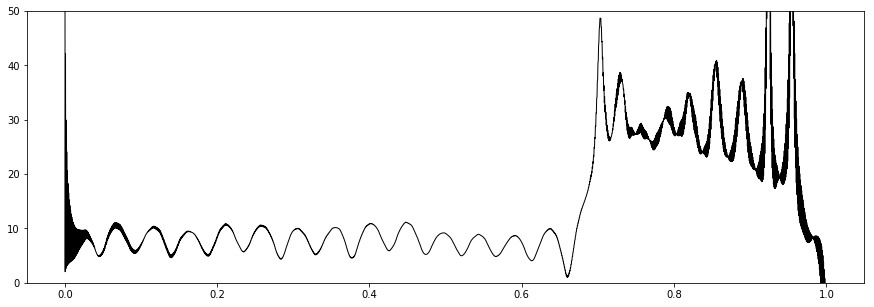

In [606]:
plt.figure(figsize=(15,5))
plt.plot(t[0:-1], instantaneous_frequency[2,:], linewidth=1, color='black', label=str(f_m[ii-1]) + 'Hz')
plt.ylim(0,50)
plt.show()

### Error

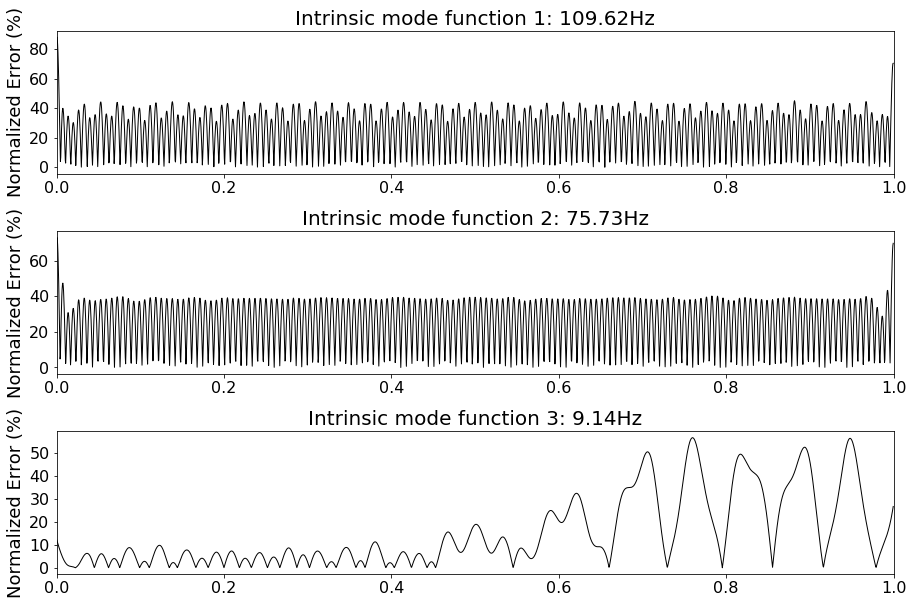

In [607]:
fig, ax = plt.subplots(figsize=(15,10))
for ii in range(1,nF+1):
    plt.subplot(nF,1,ii)
    abs_err_ptwise = np.abs(C[-ii,:] - imfs[ii-1,:])                    # absolute pointwise error
    signal_range = np.abs(np.max(C[-ii,:]) + np.abs(np.min(C[-ii,:])))  # range, absolute max - absolute min
    rel_err = 100*abs_err_ptwise/signal_range                           # relative percent error
    plt.plot(t, rel_err, linewidth=1, color='black')
    plt.xlim(0, nS)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('Normalized Error (%)', fontsize=18)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    if ii == nIMF:
        plt.xlabel('Time (s)', fontsize=20)

fig.subplots_adjust(hspace=0.4)

#plt.savefig('plots/12_ex_emd_normalized_error.pdf', bbox_inches = "tight")
plt.show()

### Example of component vs. IMF
We can see the error being made.

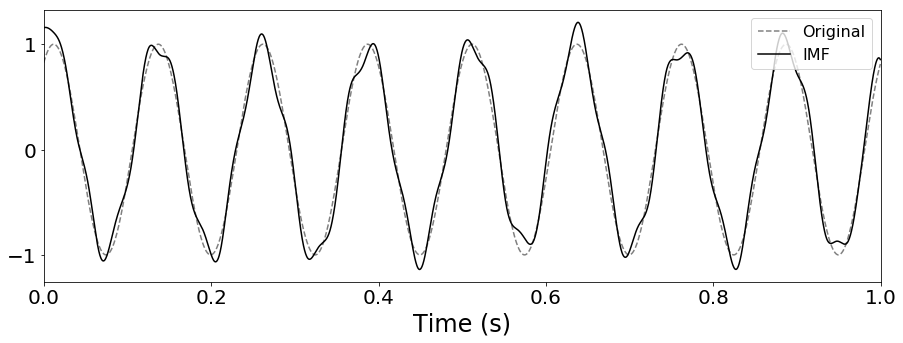

In [608]:
s1 = 0 
s2 = 1200
plt.figure(figsize=(15,5))
plt.plot(t, C[0, :], linestyle='--', color='grey', label='Original')
plt.plot(t, imfs[2, :] + imfs[3, :], color='black', label='IMF')
plt.xlim(0, nS)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time (s)', fontsize=24)
plt.locator_params(axis='y', nbins=3)
plt.legend(loc='upper right', bbox_to_anchor=(.999, 1), fontsize=16)

plt.savefig('plots/ch4-3-8_add_comps.pdf', bbox_inches = "tight")


### Inst freq

In [609]:
sig = imfs[2, :] + imfs[3, :]
analytic_sig = scipy.signal.hilbert(sig)
    
amplitude_env = np.abs(analytic_sig)
instantaneous_ph = np.unwrap(np.angle(analytic_sig))
instantaneous_freq = (np.diff(instantaneous_ph) /
                           (2.0*np.pi) * Fs)

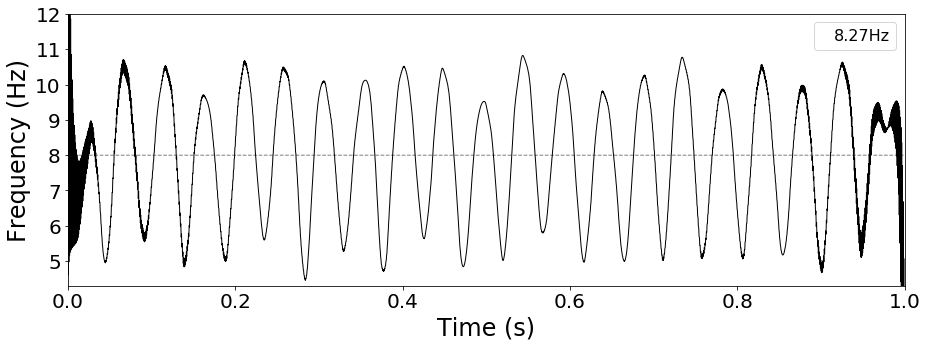

In [610]:
f_med = np.round(np.median(instantaneous_freq),2)
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, nS, len(instantaneous_freq)), 8*np.ones(shape=(len(instantaneous_freq),)), linewidth=1, linestyle='--', color='gray')
plt.plot(t[0:-1], instantaneous_freq, linewidth=1, color='black', label=str(f_med) + 'Hz')
plt.xlim(0, nS)
plt.ylim(4.3,12)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time (s)', fontsize=24)
plt.ylabel('Frequency (Hz)', fontsize=24)
plt.legend(loc='upper right', handlelength=0, bbox_to_anchor=(.999, 1), fontsize=16)

plt.savefig('plots/ch4-3-8_add_comps_inst_freq.pdf', bbox_inches = "tight")

plt.show()